In [1]:
import torch

sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss", "Xiaobing is Student", "Xiaoxue is Student"]
words = ' '.join(sentences).split()
# 去除重复单词
word_list = list(set(words))

word_to_idx = {word: idx for idx, word in enumerate(word_list)}
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
# print(word_to_idx)
# print(idx_to_word)
voc_size = len(word_list)
print("词汇表", word_list)
print("词汇到索引", word_to_idx)
print("索引到词汇", idx_to_word)
print("词汇表大小", voc_size)

词汇表 ['Teacher', 'Boss', 'Niuzong', 'is', 'Xiaoxue', 'Kage', 'Student', 'Mazong', 'Xiaobing']
词汇到索引 {'Teacher': 0, 'Boss': 1, 'Niuzong': 2, 'is': 3, 'Xiaoxue': 4, 'Kage': 5, 'Student': 6, 'Mazong': 7, 'Xiaobing': 8}
索引到词汇 {0: 'Teacher', 1: 'Boss', 2: 'Niuzong', 3: 'is', 4: 'Xiaoxue', 5: 'Kage', 6: 'Student', 7: 'Mazong', 8: 'Xiaobing'}
词汇表大小 9


In [2]:
# 获取相邻的单词，将当前单词前后各N个单词作为周围词
def create_skipgram_dataset(sentences, window_size=2):
    # print(window_size)
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            
            for neighbor in sentence[max(idx-window_size, 0):min(idx+window_size+1, len(sentence))]:
                # print(word,"=", neighbor)
                if neighbor != word:
                    data.append((neighbor, word))
    return data

skipgram_data = create_skipgram_dataset(sentences, window_size=2)
print("Skip-Gram数据样例:", skipgram_data[:3])

Skip-Gram数据样例: [('is', 'Kage'), ('Teacher', 'Kage'), ('Kage', 'is')]


In [3]:
def one_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(len(word_to_idx))
    tensor[word_to_idx[word]] = 1
    return tensor

word_example = "Xiaobing"
print(one_hot_encoding(word_example, word_to_idx))
print("skip-gram 数据样例", [(one_hot_encoding(context, word_to_idx), word_to_idx[target]) for context, target in skipgram_data[:3]])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.])
skip-gram 数据样例 [(tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]), 5), (tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 5), (tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]), 3)]


In [4]:
import torch.nn as nn
class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(SkipGram, self).__init__()
        # 从词汇表大小到嵌入层大小的线性层
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias=False)
        # 从嵌入层大小到词汇表大小的线性层
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)

    def forward(self, X):
        hidden = self.input_to_hidden(X)
        output = self.hidden_to_output(hidden)
        return output

Skip-Gram类 SkipGram(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)
Epoch 100, Loss: 2.171045668919881
Epoch 200, Loss: 2.1495506882667543
Epoch 300, Loss: 2.1245826999346415
Epoch 400, Loss: 2.093731526533763
Epoch 500, Loss: 2.0558478434880576
Epoch 600, Loss: 2.0120821555455524
Epoch 700, Loss: 1.9667045871416728
Epoch 800, Loss: 1.9252624889214833
Epoch 900, Loss: 1.8907710452874502
Epoch 1000, Loss: 1.8627850830554962


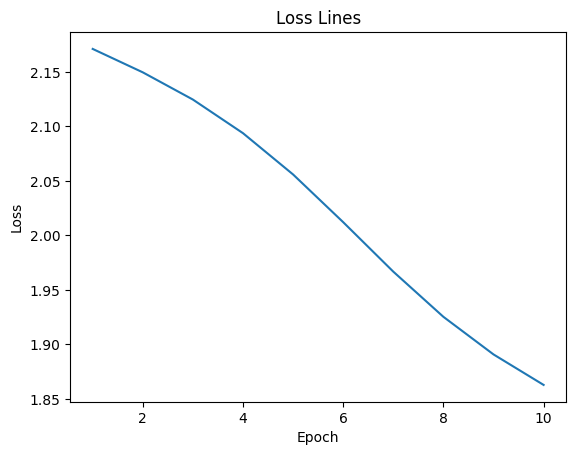

In [5]:
embedding_size=2 #嵌入层大小
skipgram_model = SkipGram(voc_size, embedding_size)
print("Skip-Gram类", skipgram_model)

learning_rate = 0.001 
epoches = 1000
loss_fn = nn.CrossEntropyLoss()
import torch.optim as optim
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)

loss_values = []
for epoch in range(epoches):
    loss_sum = 0
    for context, target in skipgram_data:
        # **skip-gram用中心词预测周围词**
        X = one_hot_encoding(target, word_to_idx).float().unsqueeze(0)
        # print(X.shape)
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long)
        # print(y_true.shape)
        y_pred = skipgram_model(X)
        # print(y_pred.shape)
        loss = loss_fn(y_pred, y_true)
        loss_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        cur_loss = loss_sum/len(skipgram_data)
        print(f"Epoch {epoch+1}, Loss: {cur_loss}")
        loss_values.append(cur_loss)

import matplotlib.pyplot as plt

plt.plot(range(1, epoches//100 + 1), loss_values)
plt.title("Loss Lines")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
skipgram_model.input_to_hidden.weight.shape

torch.Size([2, 9])

In [9]:
voc_size

9

In [7]:
print("Skip-Gram 词嵌入：")
# skipgram_model.input_to_hidden.weight 是 (embedding_size, vocab_size)的，所以用[:, idx]取对应的embedding
for word, idx in word_to_idx.items():
    print(f"{word}: {skipgram_model.input_to_hidden.weight[:,idx].detach().numpy()}")

Skip-Gram 词嵌入：
Teacher: [-0.23713465 -0.9621154 ]
Boss: [ 1.0134593 -0.9789339]
Niuzong: [ 0.19426395 -0.17909265]
is: [-0.19316025  0.77368456]
Xiaoxue: [ 0.06378833 -0.08702793]
Kage: [ 0.87139386 -0.35596186]
Student: [-0.23617339 -0.98852277]
Mazong: [ 0.42713654 -0.05758581]
Xiaobing: [ 0.2767794  -0.12097092]


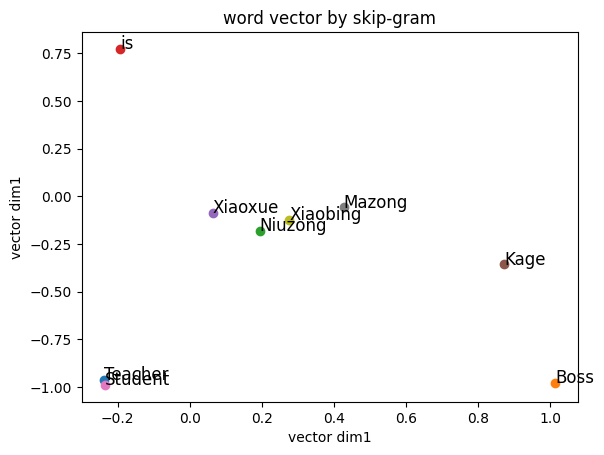

In [11]:
fig, ax = plt.subplots()
for word, idx in word_to_idx.items():
    vec = skipgram_model.input_to_hidden.weight[:, idx].detach().numpy()
    ax.scatter(vec[0], vec[1]) # 绘制向量
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 标注单词
plt.title("word vector by skip-gram")
plt.xlabel("vector dim1")
plt.ylabel("vector dim1")
plt.show()